In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [2]:
import kaggle

dataset_name = 'phylake1337/fire-dataset'
download_path = './data'

In [3]:
# 데이터가 없을 때만 다운로드 (중복 방지)

if not os.path.exists(download_path):
    try:
        kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)
        print("다운로드 완료")
    except Exception as e:
        print(f"다운로드 실패: {e}")
else:
    print("다운로드 스킵")

# 실제 폴더 구조 확인
target_root = None
for root, dirs, files in os.walk(download_path):
    level = root.replace(download_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    
    # 'fire_images'라는 폴더가 보이면 그 상위 폴더를 데이터셋 루트로 잡음
    if 'fire_images' in dirs:
        target_root = root

print(target_root)

다운로드 스킵
data/
    fire_dataset/
        non_fire_images/
        fire_images/
./data/fire_dataset


In [4]:
from collections import Counter

# 이미지 전처리 (224 * 224로 조정)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ImageFolder로 불러오기
if target_root:
    dataset = datasets.ImageFolder(root=target_root, transform=transform)
    
    # 데이터셋 분할 (학습/테스트)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # DataLoader 생성 (학습용은 섞기, 테스트용은 순차적으로)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # 데이터 로더 딕셔너리 생성 (다음 학습 단계에서 활용 용이)
    dataloaders = {'train': train_dataloader, 'test': test_dataloader}
    dataset_sizes = {'train': train_size, 'test': test_size}

    # 클래스별 이미지 수 계산 및 출력 (Counter로 간결화)
    class_indices_counts = Counter(dataset.targets)
    
    for idx, count in sorted(class_indices_counts.items()):
        class_name = dataset.classes[idx]
        print(f"- {class_name}: {count}")
        
    print(f"학습: {dataset_sizes['train']}, 테스트: {dataset_sizes['test']}")

- fire_images: 755
- non_fire_images: 244
학습: 799, 테스트: 200


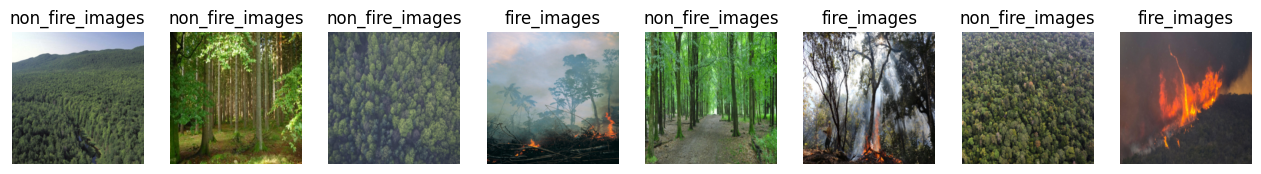

In [5]:
# 데이터셋 확인

images, labels = next(iter(train_dataloader))
plt.figure(figsize=(16, 6))

# 8장 출력
for i in range(8):
    ax = plt.subplot(1, 8, i + 1)
    img = images[i].permute(1, 2, 0)
        
    plt.imshow(img)
    plt.title(dataset.classes[labels[i]])
    plt.axis('off')
plt.show()

In [6]:
# GPU 확인

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1
0
NVIDIA GeForce RTX 4060 Ti


In [ ]:
# 모델 세팅

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 가중치 동결
for param in model.parameters():
    param.requires_grad = False

# 최종 분류 레이어(Fully Connected Layer) 수정 (기존 클래스 개수 -> 2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# 모델을 GPU에 올림
model = model.to(device)

In [ ]:
import time
import copy

# 이진 분류이므로 CrossEntropyLoss 사용
criterion = nn.CrossEntropyLoss()

# 마지막 분류 레이어의 파라미터만 학습되도록 설정
optimizer_ft = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# 10 에포크마다 학습률 0.1배씩 감소
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    # 가장 좋은 성능을 낸 모델 가중치 저장
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 40)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train() # 학습 모드
            else:
                model.eval() # 평가 모드

            running_loss = 0.0
            running_corrects = 0

            # 데이터 올리기
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # 그래디언트 초기화

                # 순전파, 학습 단계에서만 그래디언트 계산 활성화
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델 가중치를 deepcopy로 저장.
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()
        
    # 가장 좋은 가중치를 모델에 로드
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

In [17]:
# 모델 학습
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=30)

Epoch 1/30
----------------------------------------
train Loss: 0.1308 Acc: 0.9574
test Loss: 0.1778 Acc: 0.9300
Epoch 2/30
----------------------------------------
train Loss: 0.1268 Acc: 0.9562
test Loss: 0.1348 Acc: 0.9400
Epoch 3/30
----------------------------------------
train Loss: 0.1143 Acc: 0.9650
test Loss: 0.1202 Acc: 0.9500
Epoch 4/30
----------------------------------------
train Loss: 0.1095 Acc: 0.9612
test Loss: 0.1129 Acc: 0.9650
Epoch 5/30
----------------------------------------
train Loss: 0.1001 Acc: 0.9675
test Loss: 0.1106 Acc: 0.9700
Epoch 6/30
----------------------------------------
train Loss: 0.0866 Acc: 0.9762
test Loss: 0.1020 Acc: 0.9550
Epoch 7/30
----------------------------------------
train Loss: 0.0882 Acc: 0.9775
test Loss: 0.1123 Acc: 0.9500
Epoch 8/30
----------------------------------------
train Loss: 0.0799 Acc: 0.9787
test Loss: 0.0959 Acc: 0.9600
Epoch 9/30
----------------------------------------
train Loss: 0.0771 Acc: 0.9800
test Loss: 0.

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

# Confusion Matrix 시각화 함수
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

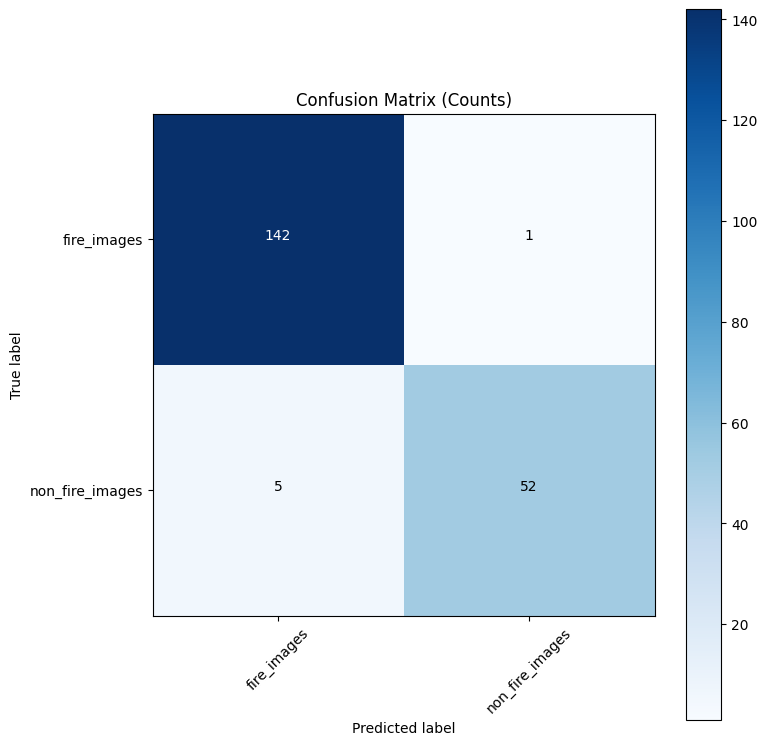

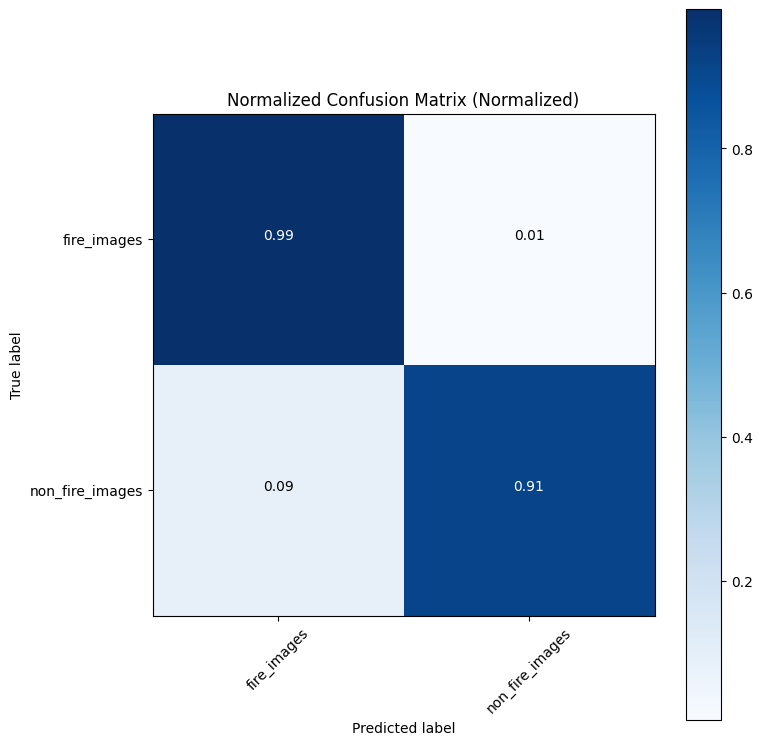

In [30]:
model.eval() # 모델을 평가 모드로 설정
all_preds = []
all_labels = []

# 테스트 데이터로더 사용
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix 생성
cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes # ['fire_images', 'non_fire_images']

# Confusion Matrix 출력
plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion Matrix (Counts)')
plot_confusion_matrix(cm, class_names, normalize=True, title='Confusion Matrix (Normalized)')

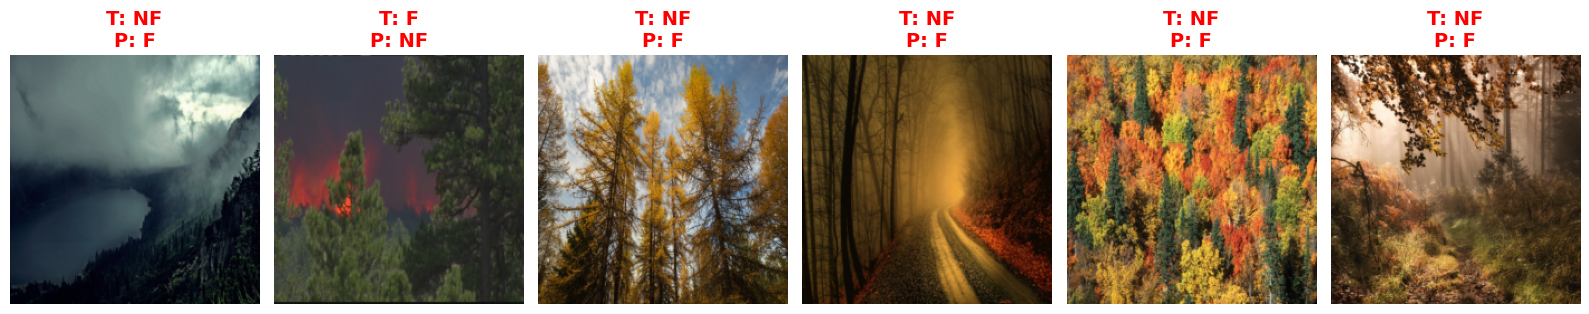

In [ ]:
# 오분류된 샘플 중 최대 10개만 시각화
misclassified_indices = np.where(np.array(all_labels) != np.array(all_preds))[0]
num_display = min(10, len(misclassified_indices)) 
display_indices = misclassified_indices[:num_display]

if num_display > 0:
    plt.figure(figsize=(16, num_display // 5 * 4))
    for i, data_idx in enumerate(display_indices):
        img_tensor, true_label_idx = test_dataset[data_idx] # 이미지, true 라벨 가져오기
        predicted_label_idx = all_preds[data_idx] # 예측 라벨 가져오기

        plt.subplot(1, num_display, i + 1)
        img = img_tensor.permute(1, 2, 0)
        
        plt.imshow(img)
        
        true_class_name = dataset.classes[true_label_idx]
        pred_class_name = dataset.classes[predicted_label_idx]
        
        # 'fire_images'와 정확히 일치할 때만 F, 아니면 NF
        true_str = 'F' if true_class_name == 'fire_images' else 'NF'
        pred_str = 'F' if pred_class_name == 'fire_images' else 'NF'
        
        plt.title(f"T: {true_str}\nP: {pred_str}", color='red', fontsize=14, fontweight='bold')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
else:
    print("오분류된 샘플 X")